In [19]:
#@title Library and Environment
import pandas as pd
import fmpsdk
import os
import dotenv
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from fmp import FMP
from PyPDF2 import PdfMerger

dotenv.load_dotenv()
apikey:str=os.getenv("apikey")
stock_symbol: str = input("Please enter stock symbol: ")

report_path:str = os.path.join("report_output",f"{stock_symbol}_finReport.pdf")
# util function
def to_percentage(num:float)->str:
  return f'{num*100:.2f} %'

def remove_prevReport(path:str):
  
  if os.path.isfile(path):
    os.remove(path)
    print(f"previous {path} is removed")
    return
  
  print(f"the directory is clean, no previous version exists")

def save_fig(path:str) -> None:
  merge_temp(path,"temp_append.pdf")

def save_dataframe(df:pd.DataFrame,title:str,  path:str) -> None:

  # table formatting
  transformed_frame:pd.DataFrame = df.map(lambda x: round(x,2) if isinstance(x,float) else x)
  tabFig , tabAx = plt.subplots()
  tabAx.axis('tight')
  tabAx.axis('off')
  
  table1 = tabAx.table(cellText=transformed_frame.values,
                        colLabels=transformed_frame.columns,
                        rowLabels=transformed_frame.index,
                        cellLoc = 'center',
                        loc='center')
  tabFig.suptitle(title)
  # 
  merge_temp(path,"temp_append.pdf")

def merge_temp(path:str,temp_pdf:str) -> None:
    with PdfPages(temp_pdf) as pdf:
      pdf.savefig()
      plt.close()
      print("figure is saved")
    merger:PdfMerger= PdfMerger()
    if os.path.exists(path):
      merger.append(path)
    merger.append(temp_pdf)
    merger.write(path)
    merger.close()
    os.remove(temp_pdf)


remove_prevReport(report_path)
print(f"Fetching financial data for {stock_symbol}...")

previous report_output\AAPL_finReport.pdf is removed
Fetching financial data for AAPL...


In [20]:
#@title JSON data

client :FMP = FMP(api_key=apikey,config_file="./fmp_endpoints.json",log_enabled=False)
keymetrics_data:list[dict]=client.call("key-metrics",symbol=stock_symbol).json()
keymetrics_data.reverse()
ratio_data:list[dict]=client.call(endpoint_name="ratios",symbol=stock_symbol).json()
ratio_data.reverse()
balance_data:list[dict]=client.call(endpoint_name="balance-sheet-statement",symbol=stock_symbol).json()
balance_data.reverse()
income_data:list[dict]=client.call(endpoint_name="income-statement",symbol=stock_symbol).json()
income_data.reverse()
cashflow_data:list[dict]=client.call(endpoint_name="cash-flow-statement",symbol=stock_symbol).json()
cashflow_data.reverse()

INFO:FMP:HTTP GET: https://financialmodelingprep.com/stable/key-metrics with params {'symbol': 'AAPL', 'apikey': 'sgAxv02G1FYfdl5NmOgfBpfQH24Rldae'}
INFO:FMP:Response: 200
INFO:FMP:HTTP GET: https://financialmodelingprep.com/stable/ratios with params {'symbol': 'AAPL', 'apikey': 'sgAxv02G1FYfdl5NmOgfBpfQH24Rldae'}
INFO:FMP:Response: 200
INFO:FMP:HTTP GET: https://financialmodelingprep.com/stable/balance-sheet-statement with params {'symbol': 'AAPL', 'apikey': 'sgAxv02G1FYfdl5NmOgfBpfQH24Rldae'}
INFO:FMP:Response: 200
INFO:FMP:HTTP GET: https://financialmodelingprep.com/stable/income-statement with params {'symbol': 'AAPL', 'apikey': 'sgAxv02G1FYfdl5NmOgfBpfQH24Rldae'}
INFO:FMP:Response: 200
INFO:FMP:HTTP GET: https://financialmodelingprep.com/stable/cash-flow-statement with params {'symbol': 'AAPL', 'apikey': 'sgAxv02G1FYfdl5NmOgfBpfQH24Rldae'}
INFO:FMP:Response: 200


,totalStockholdersEquity,totalDebt
fiscalYear,,
2021,63090000000,136522000000
2022,50672000000,132480000000
2023,62146000000,123930000000
2024,56950000000,119059000000
2025,73733000000,112377000000


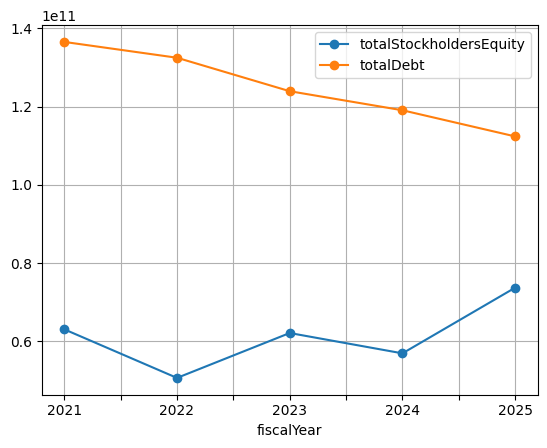

In [21]:
balance_frame=pd.DataFrame(balance_data,columns=["fiscalYear",'totalStockholdersEquity',"totalDebt"])
balance_frame=balance_frame.set_index(keys=['fiscalYear'])
balance_frame.plot(use_index=True, y=["totalStockholdersEquity","totalDebt"],marker="o",grid=True)
balance_frame.style.set_caption(f"Table for {stock_symbol}")

In [22]:
income_frame = pd.DataFrame(income_data,columns=['fiscalYear','netIncome','eps'])
income_frame=income_frame.set_index(keys=['fiscalYear'])

In [23]:

ratio_frame=pd.DataFrame(ratio_data,columns=['fiscalYear',"debtToEquityRatio","currentRatio","bookValuePerShare"])
ratio_frame=ratio_frame.set_index(keys=["fiscalYear"])
ratio_frame.style.set_caption(f"Table for {stock_symbol}")

,debtToEquityRatio,currentRatio,bookValuePerShare
fiscalYear,,,
2021,2.163925,1.074553,3.777557
2022,2.614462,0.879356,3.124822
2023,1.994175,0.988012,3.947224
2024,2.090588,0.867313,3.711601
2025,1.524107,0.893293,4.932468


<!-- @title Vigilant leader -->
## Vigilant leader

### Rule 1 - importance of `debtEquityRatio`
A  company can choose to finance its investment using its equity or debt. However, a company would have much better flexibility if it use equity. Warren Buffet like to invest in company whose `debtEquity` ratio is below `0.5`

### Rule 2 - current ratio

**Current Asset** will be converted to cash within the next 12 months such the inventory expected to be sold. On the other hand, **Current Liability** is the money that company will need to pay within next 12 months, so it could be raw material received from the supplier but they have not paid for it. `Current ratio = current asset / current liability`. Really high current ratio can indicate that the company having hardtime collecting money from the vender. If current ratio below 1, the company might have to acquire new debt to pay off the existing debt. In general, current ratio between 1.5 to 2.5 is desireable. A current ratio above 5 might indicate bad money mannagement.

### Rule 3 - Strong and consistent return on equity

ROE shows you how effective the mangement reinvest your profit in the business. `ROE = Net Income / Shareholder's Equity` Remember that `equity = asset - libility`, and all profit made will go under `equity` in the balance sheet, so ROE help us examine portion of equity that is net income. In general, we should look for companies that have a consistent ROE above `8%` over the last ten 10 years. After identifying the trend, we should also compare it with the competitor. When examing ROE, it is very important to compare it side by side with debt to equity ratio. The company can potentially use debt instead of its stockholder's equity to keep ROE consistent or even higher, so we need to be careful of company with `debtEquity ratio` higher than 0.5. Here is an example demonstrating such account tricks

![ROE accounting tricks](https://i.ibb.co/twfwHZg7/roe-accounting-tricks.png)

In the picture above, we see the company using debt instead of shareholder's equity to make ROE look nicer.

### Rule 4 - Appropriate management incentives

If a management is given the incentive to solely focus on the share price, the management is also given the incentive not to pay out dividends, but rather to retain all earnings even though there are no good projects to invest in.
You want a company that disclose how much the base salary is and how much is variable, and which indicators the management is measured on.





In [24]:
#@title table for vigilant leader

keymetric_frame=pd.DataFrame(keymetrics_data,columns=['fiscalYear',"returnOnEquity"])
keymetric_frame=keymetric_frame.set_index(keys=['fiscalYear'])
keymetric_frame=keymetric_frame.join(ratio_frame)
keymetric_frame.style.set_caption(f"Table for {stock_symbol}")

save_dataframe(keymetric_frame, f'Table 1: Key Metrics for {stock_symbol}', report_path)

figure is saved


In [25]:
# Figure 1: ROE and Debt to Equity Ratio
fig1, roeAxis = plt.subplots()
sns.lineplot(data = keymetric_frame, x=keymetric_frame.index, y='returnOnEquity', marker="o", ax=roeAxis, color='blue')
debtToEquityAxis = roeAxis.twinx()
sns.lineplot(data = keymetric_frame, x=keymetric_frame.index, y='debtToEquityRatio', marker="o", ax=debtToEquityAxis, color='orange')

debtToEquityAxis.set_ylabel('Debt to Equity Ratio', color='orange')

# Figure 1: ROE axis analysis
roe_mean:float = keymetric_frame['returnOnEquity'].mean()
roeAxis.axhline(y=roe_mean, color='blue', linestyle='--')
roeAxis.axhline(y=0.08, color='red', linestyle='--')
roeAxis.axhspan(0,0.08, color='red', alpha=0.1)

roeAxis.set_ylim(bottom=0)
roeAxis.set_ylabel('Return on Equity (ROE)', color='blue')
roeAxis.text(keymetric_frame.index[-1], roe_mean, f' Average ROE: {to_percentage(roe_mean)}', color='blue', va='bottom', ha='left')
roeAxis.text(keymetric_frame.index[-1], 0.08, ' 8% ROE Threshold', color='red', va='bottom', ha='left')

fig1.legend()
fig1.subplots_adjust(left=0.1, right=0.75, top=0.85, bottom=0.1)
fig1.suptitle(f'Figure 1: ROE and Debt to Equity Ratio for {stock_symbol}')
# fig1_secription:str = (
#     "In Figure 1 above. If ROE is constantly over 8%, the only thing that we need to watch out for is increasing DE ratio. "
#     "If DE ratio is increasing while ROE remain constant, please don't pursue this stock. "
#     "In that case, company might be using the desperate approach to stablize the ROE."
# )
# fig1.text(0.5, -0.2, s=fig1_secription, ha='center', fontsize = "x-large", wrap=True, color = "#696969")
# plt.show()
save_fig(report_path)

C:\Users\fbcha\AppData\Local\Temp\ipykernel_16080\2794930497.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig1.legend()


figure is saved


In Figure 1 above. If ROE is constantly over 8%, the only thing that we need to watch out for is increasing DE ratio. If DE ratio is increasing while ROE remain constant, please don't pursue this stock. In that case, company might be using the desperate approach to stablize the ROE.

In [17]:
# Figure 2: Debt to Equity Ratio 
fig2, debtToEquityAxis = plt.subplots()
sns.lineplot(data = keymetric_frame, x=keymetric_frame.index, y='debtToEquityRatio', marker="o", ax=debtToEquityAxis, color='orange', label='Debt to Equity Ratio')
# debtToEquityAxis.set_ylabel('Debt to Equity Ratio', color='orange')
debtToEquity_mean:float = keymetric_frame['debtToEquityRatio'].mean()
debtToEquityAxis.axhline(y=debtToEquity_mean, color='orange', linestyle='--')

# Figure 2: label the matrics
debtToEquityAxis.axhline(y = debtToEquity_mean, color='orange', linestyle='--')
debtToEquityAxis.axhline(y=0.5, color = 'green', linestyle='--')
debtToEquityAxis.axhspan(0,0.5, color='green', alpha=0.1)
debtToEquityAxis.set_ylim(bottom=0)
debtToEquityAxis.text(keymetric_frame.index[-1], debtToEquity_mean, f' Average DE Ratio: {debtToEquity_mean:.2f}', color='orange', va='bottom', ha='left')
debtToEquityAxis.text(keymetric_frame.index[0], 0.5, ' Debt to Equity Ratio Threshold: 0.5', color='green', va='bottom', ha='left')

fig2.subplots_adjust(left=0.1, right=0.75, top=0.85, bottom=0.1)
# fig2_description:str = (
#     "In Figure 2 above. A debt to equity ratio below 0.5 is considered good, indicating that the company is not overly reliant on debt financing. "
#     "A lower DE ratio suggests a more stable financial position and lower risk for investors. "
#     "Conversely, a DE ratio above 0.5 may indicate higher financial risk due to increased debt obligations."
# )
# fig2.text(0.5, -0.2, s=fig2_description, ha='center', fontsize = "x-large", wrap=True, color = "#696969")

fig2.suptitle(f'Figure 2: Debt to Equity Ratio for {stock_symbol}')

#
save_fig(report_path)

figure is saved


In figure 2, check if DE ratio is constantly below or around `0.5`. This is very important if we want to hold it for a long period of time.

In [18]:
import math
# Figure 3: Current Ratio plot
fig3, currentRatioAxis = plt.subplots()
fig3.suptitle(f'Figure 3: Current Ratio for {stock_symbol}')

sns.lineplot(data = keymetric_frame, x=keymetric_frame.index, y='currentRatio', marker="o", ax=currentRatioAxis, color='purple', label='Current Ratio')
currentRatio_mean:float = keymetric_frame['currentRatio'].mean()
# Figure 3: label the matrics
currentRatioAxis.axhline(y = currentRatio_mean, color='purple', linestyle='--')
currentRatioAxis.axhline(y=2.5, color = 'green', linestyle='--')
currentRatioAxis.axhline(y=1.5, color = 'green', linestyle='--')
currentRatioAxis.axhline(y=5, color = 'red', linestyle='--')
_,ymax = currentRatioAxis.get_ylim()
currentRatioAxis.axhspan(5,ymax, color='red', alpha=0.1)
currentRatioAxis.axhspan(1.5,2.5, color='green', alpha=0.1)
currentRatioAxis.text(keymetric_frame.index[-1], currentRatio_mean, f'average current ratio: {currentRatio_mean:.2f}', color='purple', va='bottom', ha='left')
currentRatioAxis.text(keymetric_frame.index[0], 2.5, s=f'optimal current ratio range 1.5~2.5', color='green', va='bottom', ha='left')
currentRatioAxis.text(keymetric_frame.index[0], 1.5, s=f'optimal current ratio range 1.5~2.5', color='green', va='top', ha='left')
currentRatioAxis.set_ylim(bottom=0, top= ymax)

# fig3_description:str = (
#     "In Figure 3 above. A current ratio between 1.5 and 2.5 is considered optimal, indicating that the company has a healthy balance between liquidity and efficient use of assets. "
#     "A current ratio below 1.5 may suggest potential liquidity issues, while a ratio above 2.5 could indicate that the company is not utilizing its assets effectively."
#     "As long as the current ratio is below 5 and stays consistent, it is generally acceptable."
# )
# fig3.text(0.5, -0.2, s=fig3_description, ha='center', fontsize = "x-large", wrap=True, color = "#696969")
save_fig(report_path)

figure is saved


In the Figure 3 above, really high current ratio can indicate that the company having hardtime collecting money from the vender. If current ratio below 1, the company might have to acquire new debt to pay off the existing debt. In general, current ratio between 1.5 to 2.5 is desireable. A current ratio above 5 might indicate bad money mannagement.

## Principle 2 - A company must have long-term prospect

### Rule 1 - persistent products
After 30 years, it is unlikely that consumer will not change the way they smartphone today. Warren Buffet use this question to determine whether or not he invest in a company: **"Will the Internet change the way we use the product?"**

### Rule 2 - minimize tax

A country often encourage long-term investment. You would have to pay tax on your capital gain like the ordinary income. If you hold onto an investment for more than one year, the rate is usually fixed.



## Priciple 3 - A company must be stable and understandable

### Rule 1 - stable book value growth from the owner's earning
We should look at the stability and growth of book value and earnings per share.It shows that book value growth comes from earnings. When there is increase in equity, there must be an increase in asset or decrease in liability. Dividend paid can reduce equity.

In general, we will see growth in EPS and book value per share, which would reflect in stable ROE value. Since dividend can reduce equity, we should also try to fit dividend into the trend line.


In [ ]:
#@title Principle 3 code
keymetric_frame=pd.DataFrame(keymetrics_data,columns=["fiscalYear",'netIncomePerShare','bookValuePerShare','returnOnEquity'])
keymetric_frame=keymetric_frame.set_index(keys=["fiscalYear"])

keymetric_frame.style.set_caption(f"Table for {stock_symbol}")

,netIncomePerShare,bookValuePerShare,roe
calendarYear,,,
2021,5.669029,3.777557,1.500713
2022,6.154614,3.124822,1.969589
2023,6.160669,3.947224,1.560760
2024,6.109054,3.711601,1.645935
2025,7.493060,4.932468,1.519130


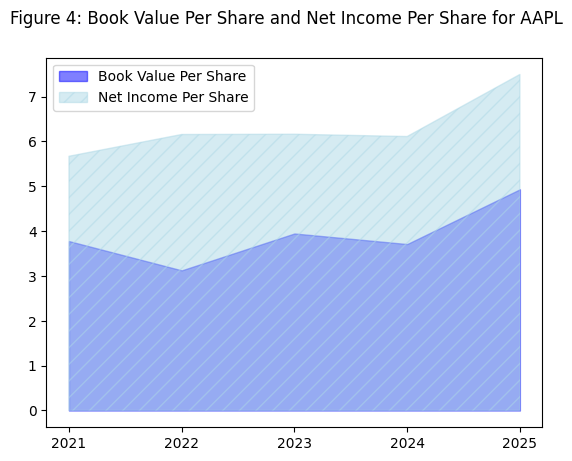

In [ ]:


plt.fill_between(keymetric_frame.index,keymetric_frame['bookValuePerShare'], color='Blue', alpha=0.5,label='Book Value Per Share')

plt.fill_between(keymetric_frame.index,keymetric_frame['netIncomePerShare'], color='lightblue', alpha=0.5,label='Net Income Per Share', hatch='//')

plt.legend()
plt.suptitle(f'Figure 4: Book Value Per Share and Net Income Per Share for {stock_symbol}')
plt.show()

## Priciple 4 -Buy at attractive prices

### Rule 1 - margin of safety

The margin of safety is the difference between the share price and the intrinsic value.

### Rule 2 - Low price-earning ratio

`PE ratio = market price of the company / net income`. Warren Buffet suggests that you buy stock with PE below 15. Estimated earning can dramatically change forward PE ratio, so we should also monitor the stability of earning.

### Rule 3 - low price-to-book ratio

`Price to book ratio = market of the company per share / equity per share`. This ratio measure how much investor pay for every $1 of company's equity. Benjamin Graham would try to find companies that had a P/B ratio below 1.5.

### Rule 4 - set a safe discount rate
By using discount rate, an investor can take a business's estimated future cash flows and discount them back to today's value. If a ten-year bond has a 3% return, the investor should never discount a ten-year investment lower than 3% annually. Discount rate are based on opportunity cost, because there might be other investment opportunities that could produce larger return with less risk.

In [ ]:
#@title Income Ratio analysis
income_columns:list[str]=['fiscalYear','revenue','grossProfitRatio','operatingIncomeRatio','netIncomeRatio','operatingIncome',"interestExpense","costOfRevenue"]
income_frame = pd.DataFrame(income_data, columns=income_columns)
income_frame=income_frame.set_index(keys=['fiscalYear'])
# calculate ratio
income_frame['Interest Coverage ratio'] = income_frame['operatingIncome'] / income_frame["interestExpense"]
# income_frame.plot(use_index=True,y=['revenue','grossProfitRatio','operatingIncomeRatio','netIncomeRatio','Interest Coverage ratio'],subplots=True,marker="o",grid=True,figsize=(10,10))

# convert ratio to formated string
income_frame['grossProfitRatio'] = income_frame['grossProfitRatio'].map(to_percentage)
income_frame['operatingIncomeRatio'] =income_frame['operatingIncomeRatio'].map(to_percentage)
income_frame['netIncomeRatio'] = income_frame['netIncomeRatio'].map(to_percentage)


income_frame.style.set_caption(f"Table for {stock_symbol}")

,revenue,grossProfitRatio,operatingIncomeRatio,netIncomeRatio,operatingIncome,interestExpense,costOfRevenue,Interest Coverage ratio
calendarYear,,,,,,,,
2021,365817000000,41.78 %,29.78 %,25.88 %,108949000000,2645000000,212981000000,41.190548
2022,394328000000,43.31 %,30.29 %,25.31 %,119437000000,2931000000,223546000000,40.749574
2023,383285000000,44.13 %,29.82 %,25.31 %,114301000000,3933000000,214137000000,29.062039
2024,391035000000,46.21 %,31.51 %,23.97 %,123216000000,0,210352000000,inf
2025,416161000000,46.91 %,31.97 %,26.92 %,133050000000,0,220960000000,inf


|                         	| Formula                             	| Note                                                                                                                                                                                                                    	|
|-------------------------	|-------------------------------------	|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------	|
| Gross profit margin     	| gross profit / revenue              	| This ratio tells us how efficient  the company is at controlling their direct cost                                                                                                                                      	|
| Operating income ratio  	| operating income / revenue          	| compared to gross profit margin, this ratio take into the secondary expense such as administration, marketing, distribution                                                                                             	|
| Net income ratio        	| Net income / revenue                	| When looking at this ratio, this is  the money that the investors made  compared to money the business collected for the sale of every product                                                                          	|
| Interest Coverage ratio 	| operating income / interest expense 	| This is very important ratio for minimizing your risk. It shows company's ability to keep its head above water. As a rule of thumb, the ratio need to be consistently above 5 for a company to be considered as stable. 	|


In [ ]:
#@title Balance sheet ratio
balance_columns:list[str]=["fiscalYear","totalCurrentAssets","inventory","totalCurrentLiabilities"]
balance_frame = pd.DataFrame(data=balance_data,columns=balance_columns)
balance_frame = balance_frame.set_index(keys=["fiscalYear"],drop=True)
balance_frame["Acid test ratio"] = (balance_frame["totalCurrentAssets"] - balance_frame["inventory"]) / balance_frame["totalCurrentLiabilities"]

# liquidity ratio
ratio_columns:list[str]=["fiscalYear","inventoryTurnover","receivablesTurnover","payablesTurnover"]
ratio_frame=pd.DataFrame(ratio_data,columns=ratio_columns)

ratio_frame = ratio_frame.set_index(keys=["fiscalYear"],drop=True)
balance_ratios=balance_frame.join(ratio_frame)


balance_ratios.style.set_caption(f"Table for {stock_symbol}")

,totalCurrentAssets,inventory,totalCurrentLiabilities,Acid test ratio,inventoryTurnover,receivablesTurnover,payablesTurnover
calendarYear,,,,,,,
2020,1092185308000,137353407000,631898400000,1.511053,4.573055,9.167390,3.191815
2021,1607072907000,193102321000,739503358000,1.912054,3.976533,8.002580,3.978068
2022,2052896744000,221149148000,944226817000,1.939944,4.139906,9.783078,3.411353
2023,2194032900000,250997100000,913583316000,2.126829,3.930822,10.701123,4.342322
2024,3088352000000,287869000000,1264525000000,2.214652,4.411572,10.637408,4.784411


|                                             	| Formula                                         	| Note                                                                                                                                                                                                                                                  	|
|---------------------------------------------	|-------------------------------------------------	|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------	|
| Acid test ratio                             	| (current asset - inventory) / current liability 	| Assuming nothing is sold in the inventory, do we still expect to to receive more than we need to pay out during next 12 month.  This is more conservative current ratio.                                                                              	|
| Inventory Turnover ratio (Efficiency ratio) 	| Cost of Revenue / Inventory average                     	| This ratio tells you how many times the inventory has been filled. It is preferable to have inventory filled 4 times and above annually. If you are working with quarterly statement, you need to multiply this number by 4.                          	|
| Receivable Turnover ratio                   	| Turnover (Revenue) / Account Receivable average         	| In general, this ratio is the number of times the cash of sales are collected. 365 days divided by this ratio usually means the number of days to collect the cash after the sales is made.  5 - 7 is optimal, but it really depends on the industry. 	|
| Payable Turnover ratio                      	| Cost of Revenue / Account Payable               	| Take 365 days divided by this ratio, we would get how many days the company pay its supplier after the purchase is made                                                                                                                               	|

,revenue,freeCashFlow,netCashUsedForInvestingActivites,operatingCashFlow,Free Cash Flow to Revenue,Investing Cash flow to Operating cash flow
calendarYear,,,,,,
2020,1339254800000,301191687000,-505781714000,822666212000,22.49 %,61.48 %
2021,1587415000000,262724263000,-836365863000,1112160722000,16.55 %,75.20 %
2022,2263891300000,520972732000,-1190928235000,1610599188000,23.01 %,73.94 %
2023,2161736000000,286568900000,-906120600000,1241967300000,13.26 %,72.96 %
2024,2894308000000,870170000000,-864842800000,1826177000000,30.06 %,47.36 %


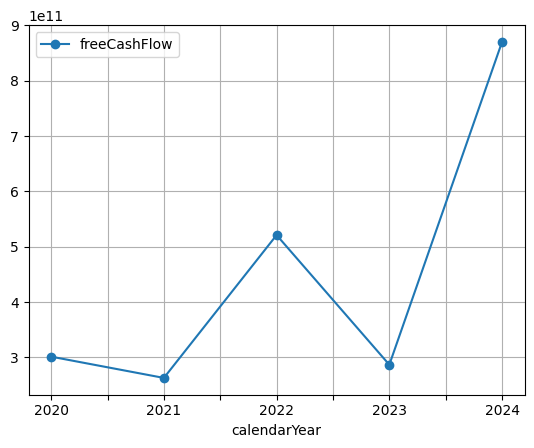

In [ ]:
cashflow_columns:list[str]=["fiscalYear","freeCashFlow","netCashUsedForInvestingActivites","operatingCashFlow"]
cashflow_frame=pd.DataFrame(cashflow_data,columns=cashflow_columns)
cashflow_frame=cashflow_frame.set_index(keys=["fiscalYear"])

income_columns:list[str]=["fiscalYear","revenue"]
income_frame=pd.DataFrame(income_data,columns=income_columns)
income_frame=income_frame.set_index(keys=["fiscalYear"])

combined_frame=income_frame.join(cashflow_frame)

# cashflow ratio

combined_frame["Free Cash Flow to Revenue"] = combined_frame["freeCashFlow"] / combined_frame["revenue"]
combined_frame["Free Cash Flow to Revenue"]=combined_frame["Free Cash Flow to Revenue"].map(to_percentage)
combined_frame["Investing Cash flow to Operating cash flow"] = -combined_frame["netCashUsedForInvestingActivites"] / combined_frame["operatingCashFlow"]
combined_frame["Investing Cash flow to Operating cash flow"]=combined_frame["Investing Cash flow to Operating cash flow"].map(to_percentage)

combined_frame.plot(use_index=True,y=["freeCashFlow"],marker="o",grid=True)

combined_frame.style.set_caption(f"Table for {stock_symbol}")


|                                                 	| Formula                                        	| Note                                                                                                                                                                                                                                         	|
|-------------------------------------------------	|------------------------------------------------	|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------	|
| Free Cash Flow                                  	| operating cash flow - Property, Equipment, net 	|                                                                                                                                                                                                                                              	|
| FCF to revenue ratio                            	| free cash flow / revenue                       	| This ratio strip away the sales on credit and measure how much cash goes from sales to owner. It is optimal to see at least 5%  over the years                                                                                               	|
| Investing cash flow to operating cashflow ratio 	| Investing cash flow / operating cashflow       	| This ratio measures how much cash goes from daily operation to reinvestment of the company. Assuming Pepsi has 60% and Coke has 50%, we would  find Coke more attractive, because less shareholder's  money is tied up to grow the business  	|